In [3]:
import pyworld as pw
from scipy.io import wavfile
import numpy as np
import pysptk
import matplotlib.pyplot as plt
import os
from glob import glob
from dtw import dtw
from numpy.linalg import norm
import chainer
from chainer import Variable, serializers, Chain, cuda,optimizers
import chainer.functions as F
import chainer.links as L

In [4]:
source="rms"
target="slt"

In [6]:
source_path_list=glob(os.path.join("","train/"+source+"/*.wav"))
target_path_list=glob(os.path.join("","train/"+target+"/*.wav"))
source_fs=[]#入力のサンプリング周波数
source_data=[]#入力のデータ
target_fs=[]#出力のサンプリング周波数
target_data=[]#出力のデータ
source_raw_f0=[]#基本周波数
target_raw_f0=[]
source_t=[]
target_t=[]
source_f0=[]#修正された基本周波数
target_f0=[]
source_sp=[]#スペクトル包絡
target_sp=[]
source_ap=[]#非周期成分
target_ap=[]
source_mc=[]#MCEP
target_mc=[]
source_aligned_mc=[]#同期されたMCEP
target_aligned_mc=[]

#for i in range(len(source_path_list)):#データの読み込み
for i in range(50):
    source_fs.append(wavfile.read(source_path_list[i])[0])
    source_data.append(wavfile.read(source_path_list[i])[1])
    target_fs.append(wavfile.read(target_path_list[i])[0])
    target_data.append(wavfile.read(target_path_list[i])[1])
    source_data[i]=source_data[i].astype(np.float)
    target_data[i]=target_data[i].astype(np.float)

print("Data Loaded")
    
#for i in range(len(source_path_list)):#各特徴量の抽出
for i in range(50):
    source_raw_f0.append(pw.dio(source_data[i],source_fs[i])[0])
    source_t.append(pw.dio(source_data[i],source_fs[i])[1])
    source_f0.append(pw.stonemask(source_data[i],source_raw_f0[i],source_t[i],source_fs[i]))
    source_sp.append(pw.cheaptrick(source_data[i],source_f0[i],source_t[i],source_fs[i]))
    source_ap.append(pw.d4c(source_data[i],source_f0[i],source_t[i],source_fs[i]))
    source_mc.append(pysptk.sp2mc(source_sp[i],24,pysptk.util.mcepalpha(source_fs[i])))
    target_raw_f0.append(pw.dio(target_data[i],target_fs[i])[0])
    target_t.append(pw.dio(target_data[i],target_fs[i])[1])
    target_f0.append(pw.stonemask(target_data[i],target_raw_f0[i],target_t[i],target_fs[i]))
    target_sp.append(pw.cheaptrick(target_data[i],target_f0[i],target_t[i],target_fs[i]))
    target_ap.append(pw.d4c(target_data[i],target_f0[i],target_t[i],target_fs[i]))
    target_mc.append(pysptk.sp2mc(target_sp[i],24,pysptk.util.mcepalpha(target_fs[i])))
    
print("Features Extracted")
    
#for i in range(len(source_path_list)):#dtwを用いて同期化
for i in range(50):
    dist,cost,acc_cost,path=dtw(source_mc[i],target_mc[i],dist=lambda x, y: norm(x - y, ord=1))
    source_aligned_mc.append(source_mc[i][path[0]])
    target_aligned_mc.append(target_mc[i][path[1]])
    
print("Time Wrapped")


Data Loaded
Features Extracted
Time Wrapped


In [7]:
source_list=[]
target_list=[]
#for i in range(len(source_path_list)):
for i in range(50):
    source_list.append(np.array(source_aligned_mc[i],dtype=np.float32))
    target_list.append(np.array(target_aligned_mc[i],dtype=np.float32))
                      

In [8]:
gpu_id = None

if gpu_id is not None:
    xp = cuda.cupy
else:
    xp = np

class VCBLSTM(chainer.Chain):
    
    def __init__(self,io_size=25,layer1_size=128,layer2_size=256):
        super(VCBLSTM,self).__init__(
            Linear_input=L.Linear(io_size,layer1_size),
            #BLSTM1=L.NStepBiLSTM(1,layer1_size,layer2_size,0.5),
            #BLSTM2=L.NStepBiLSTM(1,layer2_size,layer1_size,0.5),
            BLSTM=L.NStepBiLSTM(2,128,128,0.5),
            #Linear_output=L.Linear(layer1_size,io_size),
            Linear_output=L.Linear(256,25)
        )

        #self.reset_state()

        #if gpu_id is not None:
        #    cuda.get_device(gpu_id).use()
        #    self.to_gpu(gpu_id)
            
    def __call__(self,source):
        hx=None
        cx=None
        Lin=self.Linear_input(Variable(xp.array(source,dtype=xp.float32)))
        #hx1,cx1,ys1 = self.BLSTM1(hx,cx,Lin)
        #hx2,cx2,ys2 = self.BLSTM2(hs,cx,ys1)
        xs=[]
        xs.append(Lin)
        hx2,cx2,ys2=self.BLSTM(hx,cx,xs)
        #Lout=self.Linear_output(ys2)
        Lout=self.Linear_output(ys2[0])
        return Lout
        
#    def reset_state(self):
#        hx1=None
#        hx2=None
#        cx1=None
#        cx2=None

    def loss(self,source,target):
        y=self(source)
        return F.mean_squared_error(y,target)
    
    def load_model(self,file_name):
        serializers.load_npz(file_name, self)
    
    def save_model(self,file_name):
        serializers.save_npz(file_name,self)

In [10]:
model=VCBLSTM()
optimizer=optimizers.Adam()
optimizer.setup(model)

epoch_num=10
for epoch in range(epoch_num):
    print("{0} / {1} epoch start.".format(epoch + 1, epoch_num))
    for i in range(50):
        loss=0.0
        #model.reset_state()
        model.cleargrads()
        loss=model.loss(source_list[i],target_list[i])
        loss.backward()
        #loss.unchain_backward()
        optimizer.update()
model_file="trained_model/VCBLSTM.model"
model.save_model(model_file)
    

1 / 10 epoch start.
2 / 10 epoch start.
3 / 10 epoch start.
4 / 10 epoch start.
5 / 10 epoch start.
6 / 10 epoch start.
7 / 10 epoch start.
8 / 10 epoch start.
9 / 10 epoch start.
10 / 10 epoch start.


In [215]:
source_test_path_list=glob(os.path.join("","test/"+source+"/*.wav"))
target_test_path_list=glob(os.path.join("","test/"+target+"/*.wav"))

In [219]:
source_test_fs=[]#入力のサンプリング周波数
source_test_data=[]#入力のデータ
target_test_fs=[]#出力のサンプリング周波数
target_test_data=[]#出力のデータ
source_test_raw_f0=[]#基本周波数
target_test_raw_f0=[]
source_test_t=[]
target_test_t=[]
source_test_f0=[]#修正された基本周波数
target_test_f0=[]
source_test_sp=[]#スペクトル包絡
target_test_sp=[]
source_test_ap=[]#非周期成分
target_test_ap=[]
source_test_mc=[]#MCEP
target_test_mc=[]
source_test_aligned_mc=[]#同期されたMCEP
target_test_aligned_mc=[]

for i in range(5):
    source_test_fs.append(wavfile.read(source_test_path_list[i])[0])
    source_test_data.append(wavfile.read(source_test_path_list[i])[1])
    target_test_fs.append(wavfile.read(target_test_path_list[i])[0])
    target_test_data.append(wavfile.read(target_test_path_list[i])[1])
    source_test_data[i]=source_test_data[i].astype(np.float)
    target_test_data[i]=target_test_data[i].astype(np.float)
    
#for i in range(len(source_path_list)):#各特徴量の抽出
for i in range(5):
    source_test_raw_f0.append(pw.dio(source_test_data[i],source_test_fs[i])[0])
    source_test_t.append(pw.dio(source_test_data[i],source_test_fs[i])[1])
    source_test_f0.append(pw.stonemask(source_test_data[i],source_test_raw_f0[i],source_test_t[i],source_test_fs[i]))
    source_test_sp.append(pw.cheaptrick(source_test_data[i],source_test_f0[i],source_test_t[i],source_test_fs[i]))
    source_test_ap.append(pw.d4c(source_test_data[i],source_test_f0[i],source_test_t[i],source_test_fs[i]))
    source_test_mc.append(pysptk.sp2mc(source_test_sp[i],24,pysptk.util.mcepalpha(source_test_fs[i])))
    target_test_raw_f0.append(pw.dio(target_test_data[i],target_test_fs[i])[0])
    target_test_t.append(pw.dio(target_test_data[i],target_test_fs[i])[1])
    target_test_f0.append(pw.stonemask(target_test_data[i],target_test_raw_f0[i],target_test_t[i],target_test_fs[i]))
    target_test_sp.append(pw.cheaptrick(target_test_data[i],target_test_f0[i],target_test_t[i],target_test_fs[i]))
    target_test_ap.append(pw.d4c(target_test_data[i],target_test_f0[i],target_test_t[i],target_test_fs[i]))
    target_test_mc.append(pysptk.sp2mc(target_test_sp[i],24,pysptk.util.mcepalpha(target_test_fs[i])))
    

In [221]:
source_test_mc[0].shape

(670, 25)

In [225]:
src=source_test_mc[0]

In [223]:
tgt=model(src)

In [224]:
tgt

variable([[ 0.01385546,  0.01696279, -0.01314463, ..., -0.04406894,
           -0.00150739,  0.0237758 ],
          [-0.00096869, -0.00297089, -0.0408623 , ..., -0.02576182,
           -0.04115073,  0.02746584],
          [ 0.02649166,  0.01591729, -0.01742974, ..., -0.01571116,
           -0.04514096,  0.00591396],
          ...,
          [-0.00466983, -0.01846859, -0.06832156, ..., -0.01964105,
            0.04595092, -0.02296492],
          [-0.00834209,  0.00359597, -0.02888827, ..., -0.05302402,
            0.04859642,  0.01711123],
          [-0.0273608 ,  0.02821977, -0.01500686, ..., -0.03382013,
            0.05959612, -0.00987086]])

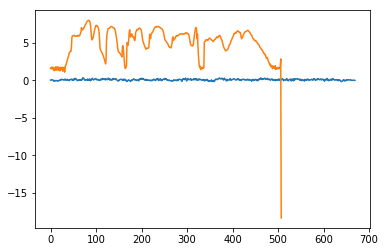

In [233]:
plt.plot(tgt.data[:,0])
plt.plot(target_test_mc[0][:,0])

In [234]:
target_test_mc[0]

array([[ 1.56269256e+00,  1.22021853e+00,  8.99369141e-01, ...,
        -1.74418755e-02,  1.07872269e-02,  9.14327165e-04],
       [ 1.53553293e+00,  1.02236170e+00,  8.28062926e-01, ...,
        -4.80489510e-02, -3.93595650e-03,  3.09818882e-02],
       [ 1.71363600e+00,  1.31789300e+00,  8.14527786e-01, ...,
        -1.13456437e-01,  1.53809468e-01, -1.54100083e-01],
       ...,
       [ 1.81496172e+00,  1.31737636e+00,  6.55481824e-01, ...,
         5.77305686e-02, -6.61690891e-02,  4.78307588e-02],
       [ 2.82693432e+00,  1.66078580e+00,  3.40090402e-01, ...,
         3.70651360e-02, -3.24073190e-02,  1.84343161e-02],
       [-1.83140711e+01,  6.62044755e-03,  7.08175134e-02, ...,
         1.83842062e-02,  2.67870789e-02, -1.37654482e-02]])

In [235]:
src

array([[ 0.1037325 , -0.08512665,  0.32886123, ...,  0.06530973,
        -0.07866588,  0.07901586],
       [ 1.00350152,  0.2994582 ,  0.15715624, ...,  0.02270624,
         0.00147088, -0.03327196],
       [ 0.57713508, -0.23090742, -0.17594192, ..., -0.01782298,
         0.0175421 ,  0.00240559],
       ...,
       [ 0.60095543,  0.12400639,  0.12669858, ..., -0.00997504,
         0.04447293, -0.04205139],
       [ 0.64179181,  0.05040951,  0.19982244, ..., -0.01092711,
        -0.01557124,  0.04155448],
       [ 0.29323326,  0.27887262,  0.50504409, ..., -0.05879085,
         0.05999155, -0.0536637 ]])

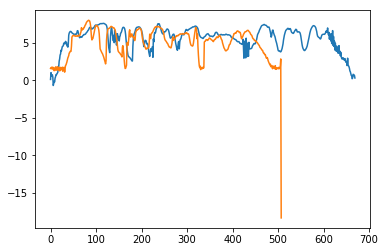

In [237]:
plt.plot(src[:,0])
plt.plot(target_test_mc[0][:,0])